# Generative Adversarial Networks

We have so far exclusively treated neural networks as classifiers and regressors, but neglected the high dimensional information that the network is creating. In a nutshell, why just classifying images and not just creating some? Can we run a neural network the other way round to create images, speech, text or whatever else we normally just feed in? 

Convolution reduces spatial information (2D images or 1D time series) to components by means of filters. The filters have usually been trained based on a large number of examples, describing features that these examples have in common. The result of the convolutional layers is then a representation that describes how much of each feature has been in the original image. This process could also be used the other way round to generate images using "deconvolution". Instead of reducing high-dimensional information such as an image to low-dimensional one, such as a distribution over classes, such networks could be generate high-dimensional images from a few numbers that define the desired content.

## Upsampling and "Deconvolving"
The label "deconvolution" is unfortunately confusing here, however, as it has established <a href="https://en.wikipedia.org/wiki/Deconvolution">mathematical meaning</a>, which is usually not implemented in a neural network context. Rather, we can achieve the desired effect by first upsampling the input and performing a convolution then. In this example, a simple (2,2) image will be turned into a (4,4) image. What exactly happens is random, as the initial weights are random, and running the model below a couple of times will give the idea.

[[1 2]
 [3 4]]
[[1.1149725  2.103928   2.229945   0.25203347]
 [2.9510407  3.9399962  4.066013   0.43501008]
 [3.3449173  4.3338733  4.45989    0.50406694]
 [0.5908152  0.75322515 0.7877536  0.13811374]]


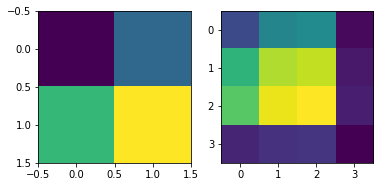

In [12]:
# Code inspired by https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/
from numpy import asarray
from keras.models import Sequential
from keras.layers import UpSampling2D
import matplotlib.pyplot as plt

# define input data
X = asarray([[1, 2],
            [3, 4]])
# show input data for context
print(X)
# reshape input data into one sample a sample with a channel
X = X.reshape((1, 2, 2, 1))
model = Sequential()
model.add(UpSampling2D(input_shape=(2, 2, 1)))
model.add(Conv2D(1, (2,2), padding='same'))
#model.summary()
yhat = model.predict(X)
# reshape output to remove channel to make printing easier
yhat = yhat.reshape((4, 4))
# summarize output
print(yhat)

plt.subplot(1,2,1)
plt.imshow(X.reshape((2,2)))
plt.subplot(1,2,2)
plt.imshow(yhat)

Keras provides a function to combine convolution and upsampling <code>Conv2DTranspose</code> that pads new rows and columns during upsampling with zeros. This can be seen when using (1,1) as a convolution kernel. 

[[1 2]
 [3 4]]
[[ 0.35152036  0.6204863   0.7030407   1.2409726 ]
 [-0.35024494 -0.4251445  -0.7004899  -0.850289  ]
 [ 1.0545611   1.861459    1.4060814   2.4819453 ]
 [-1.0507348  -1.2754335  -1.4009798  -1.700578  ]]


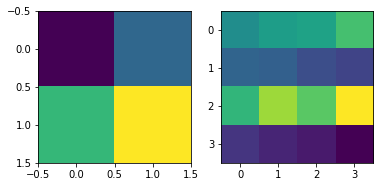

In [18]:
# Code inspired by https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/

# example of using the transpose convolutional layer
from numpy import asarray
from keras.models import Sequential
from keras.layers import Conv2DTranspose
# define input data
X = asarray([[1, 2],
            [3, 4]])
# show input data for context
print(X)
# reshape input data into one sample a sample with a channel
X = X.reshape((1, 2, 2, 1))
# define model
model = Sequential()
# Use different kernels (1,1), (2,2) etc to see how Conv2DTranspose operates
model.add(Conv2DTranspose(1, (2,2), strides=(2,2), input_shape=(2, 2, 1)))
#model.summary()
# make a prediction with the model
yhat = model.predict(X)
# reshape output to remove channel to make printing easier
yhat = yhat.reshape((4, 4))
# summarize output
print(yhat)

plt.subplot(1,2,1)
plt.imshow(X.reshape((2,2)))
plt.subplot(1,2,2)
plt.imshow(yhat)

## Finding the right kernels to get meaningful output

Lets assume a training set consists of single pixel images, which color is drawn from a 3D normal distribution centered around the color orange. The "generator" G() does not know this distribution, but turns uniform random input drawn from a distribution z into other random colors. The "discriminator" has learned the original distribution and can say "hot" (yes) or "cold" (no) and anything in between. The network can now use this feedback to improve the generator to better match the true distribution. Once gradient information is available, the generator can change its weights to get closer and closer to the desired distribution. This is known as backpropagation. 

At the same time, we can use knowledge of the fact that generated images are fake to improve the discriminator. Instead of training the discriminator with samples of shades of orange and totally random colors, we are training it with whatever the generator currently produces as examples of "fake" data. This will let the discriminator become more subtle over time.

Training both generator and discriminator sounds like a chicken-egg problem, but is usually bootstrapped by implementing a generating network that is believed to have a sufficiently complex structure to create a variety of output that we are interested in. 

### Generator
A generator is using upsampling and convolution operations to turn a seed of noise into an image. Initially, the generated images are just noise, but will eventually show similar distributions as the training set. The generator itself is never trained as a stand-alone network, which is indicated by all parameters colored in light gray. Once this network is trained, the generator gets better and better, here showing the output after zero and 2000 training iterations, which will be explained further below. 

<center>
    <img src="figs/GAN_generator.svg" width="60%">
</center>

### Discriminator
We use a discriminator to decide whether an image is following the desired distribution, i.e. like the training set, or a generated image. We can train this discriminator by using two batches of equal size, one of which contains training images, the other generated images. The generated images are labeled by a zero, the training images by a one.

<center>
    <img src="figs/GAN_discriminator.svg" width="50%">
</center>

As the generator gets better, the discriminator will get presented with better and better generated images, becoming more and more sophisticated. Here, the training set at 0 and after 2000 iterations of training the generator are shown.


### Combining Generator and Discriminator into an Adversial Network
A GAN consists of a generator and a discriminator network that are connected in series. When training the GAN, the generator pretends that images it generates are real images, which leads to a loss if the discriminator detects the fake image. In order to prevent this loss from backpropagating into the discriminator, all discriminator parameters are locked during training, which is indicated by all parameters of the discriminator shown in light gray.  

<center>
    <img src="figs/GAN_adversarial.svg" width="75%">
</center>

# Building a GAN

The implementation below has been inspired by <a href="https://github.com/roatienza/Deep-Learning-Experiments">Rowel Atienza's code</a>, and adapted to Keras 2.0. The architecture below follows the guidelines from <a href="https://arxiv.org/pdf/1511.06434.pdf%C3%AF%C2%BC%E2%80%B0">UNSUPERVISED REPRESENTATION LEARNING
WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS</a>

- Architecture guidelines for stable Deep Convolutional GANs
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.utils import np_utils

Using TensorFlow backend.


In [16]:
noise_dim = 100 # 100 gives good results

In [8]:
discriminator = Sequential()
depth = 64
dropout = 0.4
# In: 28 x 28 x 1, depth = 1
# Out: 14 x 14 x 1, depth=64
input_shape = (28, 28, 1)
discriminator.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*2, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*4, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*8, 5, strides=1, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

# Out: 1-dim probability
discriminator.add(Flatten())
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))
discriminator.summary()

optimizer = RMSprop(lr=0.0002, decay=6e-8)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)        

In [9]:
generator = Sequential()
dropout = 0.4
depth = 64+64+64+64
dim = 7
# In: 100
# Out: dim x dim x depth
generator.add(Dense(dim*dim*depth, input_dim=noise_dim))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))
generator.add(Reshape((dim, dim, depth)))
generator.add(Dropout(dropout))

# In: dim x dim x depth
# Out: 2*dim x 2*dim x depth/2
generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

# Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
generator.add(Conv2DTranspose(1, 5, padding='same'))
generator.add(Activation('sigmoid'))
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             25088     
_________________________________________________________________
batch_normalization_5 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_8 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 128)      

In [12]:
optimizer = RMSprop(lr=0.0001, decay=3e-8)
adversarial = Sequential()
adversarial.add(generator)
adversarial.add(discriminator)
adversarial.summary()
adversarial.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         1152385   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 4311553   
Total params: 5,463,938
Trainable params: 5,438,402
Non-trainable params: 25,536
_________________________________________________________________


In [13]:
(x_train, Y_train), (x_test, Y_test) = mnist.load_data()
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000, 28,28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# normalize
#
x_train /= 255
x_test /= 255
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(Y_train, 10)
y_test = np_utils.to_categorical(Y_test, 10)

In [15]:
train_steps=1000
batch_size=256
save_interval=100

def plot_images(save2file=False, fake=True, samples=16, noise=None, step=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, noise_dim])
        else:
            filename = "mnist_%d.png" % step
        images = generator.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [28,28])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

noise_input = None
if save_interval>0:
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, noise_dim])
    
a_loss = np.zeros((train_steps,2))
d_loss = np.zeros((train_steps,2))

for i in range(train_steps):
    images_train = x_train[np.random.randint(0,x_train.shape[0], size=batch_size), :, :, :]
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])
    images_fake = generator.predict(noise)
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0
    discriminator.trainable = True
    #discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy']) # slows down, why?
    d_loss[i] = discriminator.train_on_batch(x, y)
    discriminator.trainable = False
    #adversarial.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy']) # slows down, why?
    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])
    a_loss[i] = adversarial.train_on_batch(noise, y)
    log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[i,0], d_loss[i,1])
    log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[i,0], a_loss[i,1])
    print(log_mesg)
    if save_interval>0:
        if (i+1)%save_interval==0:
            plot_images(save2file=True, samples=noise_input.shape[0],noise=noise_input, step=(i+1))



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.030305, acc: 0.990234]  [A loss: 0.034259, acc: 0.984375]
1: [D loss: 0.030716, acc: 0.992188]  [A loss: 0.022632, acc: 1.000000]
2: [D loss: 0.015224, acc: 0.998047]  [A loss: 0.025762, acc: 0.996094]
3: [D loss: 0.014097, acc: 0.998047]  [A loss: 0.021311, acc: 0.996094]
4: [D loss: 0.016068, acc: 1.000000]  [A loss: 0.065851, acc: 0.980469]
5: [D loss: 0.030780, acc: 1.000000]  [A loss: 4.214302, acc: 0.015625]
6: [D loss: 0.054648, acc: 0.994141]  [A loss: 1.058146, acc: 0.492188]
7: [D loss: 0.008915, acc: 1.000000]  [A loss: 2.120664, acc: 0.816406]
8: [D loss: 0.119705, acc: 0.966797]  [A loss: 11.647167, acc: 0.000000]
9: [D loss: 0.382366, acc: 0.835938]  [A loss: 0.057759, acc: 0.968750]
10: [D loss: 0.340357, acc: 0.810547]  [A loss: 0.666597, acc: 0.699219]
11: [D loss: 0.031309, acc: 0.996094]  [A loss: 0.267225, acc: 0.886719]
12: [D loss: 0.036863, acc: 0.998047]  [A loss: 0.147826, acc: 0.929688]
13: [D loss: 0.035295, acc: 1.000000]  [A loss: 0.192481, ac

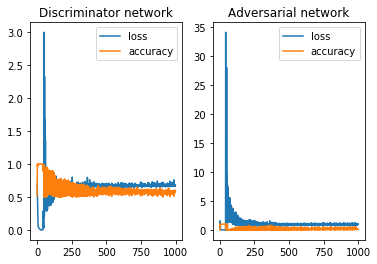

In [34]:
plt.subplot(1,2,1)
plt.title('Discriminator network')
plt.plot(d_loss[:,:])
plt.legend(discriminator.metrics_names)


plt.subplot(1,2,2)
plt.title('Adversarial network')
plt.plot(a_loss[:,:])
plt.legend(adversarial.metrics_names)


<img src="figs/GAN_mnist.gif">

# Observations
- GAN architecture not set in stone. Key idea: use "discriminator" to generate self-supervised training examples and use backpropagation to train the "generator" to trick the discriminator. 
- Other example: derive generator structure to generate camouflage patterns. Use detector to detect object. Backpropagation will change generator to minimize detection.
- Games: generator to generate move, discriminator to decide whether move was good
- Controllers: generator to generate controller "phenotype", discriminator to decide whether controller is good
- Fine balance between improving generator and discriminator is needed and the approach does not necessarily need to succeed.
- The amount of randomness you are using impacts the variety of the output you are getting. Below are three snapshots after 1000 iterations trained with 100, 10, and 1 random number as input:

<center>
<img src="figs/mnist-gan-100/mnist_1000.png" width="25%"><img src="figs/mnist-gan-10/mnist_1000.png" width="25%">
    <img src="figs/mnist-gan-1/mnist_1000.png" width="25%">
</center>